# «Модель прогнозирования стоимости жилья для агентства недвижимости»

Агентство недвижимости столкнулось с проблемой — риелторы тратят слишком много времени на сортировку объявлений и поиск выгодных предложений. Поэтому скорость их реакции и качество анализа не дотягивают до уровня конкурентов. Это сказывается на финансовых показателях агентства.

Цель — разработать модель машинного обучения, которая поможет обрабатывать объявления и увеличит число сделок и прибыль агентства.

Описание предоставленных данных:

➔ 'status' — статус продажи;

➔ 'private pool' и 'PrivatePool' — наличие собственного бассейна;

➔ 'propertyType' — тип объекта недвижимости;

➔ 'street' — адрес объекта;

➔ 'baths' — количество ванных комнат;

➔ 'homeFacts' — сведения о строительстве объекта (содержит несколько типов сведений, влияющих на оценку объекта);

➔ 'fireplace' — наличие камина;

➔ 'city' — город;

➔ 'schools' — сведения о школах в районе;

➔ 'sqft' — площадь в футах;

➔ 'zipcode' — почтовый индекс;

➔ 'beds' — количество спален;

➔ 'state' — штат;

➔ 'stories' — количество этажей;

➔ 'mls-id' и 'MlsId' — идентификатор MLS (Multiple Listing Service, система мультилистинга);

➔ 'target' — цена объекта недвижимости **(целевой признак, который необходимо спрогнозировать)**.

---

In [1]:
# Импорт библиотек
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import plotly.express as px
import plotly.graph_objects as go
import seaborn as sns

from sklearn import preprocessing
from sklearn import model_selection
from sklearn import tree
from sklearn import ensemble
from sklearn import metrics
from sklearn.linear_model import LinearRegression
from sklearn.feature_selection import RFE
from sklearn.ensemble import GradientBoostingRegressor
from catboost import CatBoostRegressor
import optuna
import pickle

-----
*Подготовка функций, которые будем использовать в процессе очистки данных и обучения моделей*

In [2]:
def outliers_iqr_mod(data, feature, left=1.5, right=1.5):
    """ 
    Функция удаления выбросов по методу Тьюки
    """
    
    x = data[feature]
    quartile_1, quartile_3 = x.quantile(0.25), x.quantile(0.75),
    iqr = quartile_3 - quartile_1
    lower_bound = quartile_1 - (iqr * left)
    upper_bound = quartile_3 + (iqr * right)
    outliers = data[(x<lower_bound) | (x> upper_bound)]
    cleaned = data[(x>lower_bound) & (x < upper_bound)]
    
    return outliers, cleaned


def metrics_fun(y_train, y_train_pred, y_test, y_test_predict, df, model_params, model_name):
    """ Функция вывода метрик метрик для выборок и занесения их в датафрейм

    Args:
        y_train: тренировочные данные, 
        y_train_pred: предсказание модели на тренировочных данных, 
        y_test: ттестовые данные, 
        y_test_predict: предсказание модели на тестовых данных, 
        df: датафрейм, 
        model_params: параметры модели, 
        model_name: Название модели

    Returns:
        DateFrame: возвращает датафрейм с новой строкой модели
    """

    print('\t Train \t\t Test')
    print('MAE: \t {:.2f} \t {:.2f}'.format(metrics.mean_absolute_error(y_train, y_train_pred), 
                                            metrics.mean_absolute_error(y_test, y_test_predict)))
    print('MSE: \t {:.0f} \t {:.0f}'.format(metrics.mean_squared_error(y_train, y_train_pred), 
                                            metrics.mean_squared_error(y_test, y_test_predict)))
    print('R2: \t {:.2f} \t\t {:.2f}'.format(metrics.r2_score(y_train, y_train_pred), 
                                             metrics.r2_score(y_test, y_test_predict)))
    print('MAPE: \t {:.3f} % \t {:.3f} %'.format(metrics.mean_absolute_percentage_error(y_train, y_train_pred) * 100, 
                                                 metrics.mean_absolute_percentage_error(y_test, y_test_predict) * 100))
    

    new_line = df.shape[0]
    df.loc[new_line, 'model_name'] = model_name
    df.loc[new_line, 'model_params'] = str(model_params)
    df.loc[new_line, 'R2_train'] = round(metrics.r2_score(y_train, y_train_pred), 2)
    df.loc[new_line, 'R2_test'] = round(metrics.r2_score(y_test, y_test_predict), 2)
    df = df.sort_values(['R2_test', 'R2_train'], ascending=False)
    return df

---
## Анализ данных

In [3]:
data = pd.read_csv('data\data.csv') # прочитаем данные
data.head(5) # вывод первыъ 5 строк датафрейма

,status,private pool,propertyType,street,baths,homeFacts,fireplace,city,schools,sqft,zipcode,beds,state,stories,mls-id,PrivatePool,MlsId,target
0,Active,NaN,Single Family Home,240 Heather Ln,3.5,"{'atAGlanceFacts': [{'factValue': '2019', 'fac...",Gas Logs,Southern Pines,"[{'rating': ['4', '4', '7', 'NR', '4', '7', 'N...",2900,28387,4,NC,NaN,NaN,NaN,611019,"$418,000"
1,for sale,NaN,single-family home,12911 E Heroy Ave,3 Baths,"{'atAGlanceFacts': [{'factValue': '2019', 'fac...",NaN,Spokane Valley,"[{'rating': ['4/10', 'None/10', '4/10'], 'data...","1,947 sqft",99216,3 Beds,WA,2.0,NaN,NaN,201916904,"$310,000"
2,for sale,NaN,single-family home,2005 Westridge Rd,2 Baths,"{'atAGlanceFacts': [{'factValue': '1961', 'fac...",yes,Los Angeles,"[{'rating': ['8/10', '4/10', '8/10'], 'data': ...","3,000 sqft",90049,3 Beds,CA,1.0,NaN,yes,FR19221027,"$2,895,000"
3,for sale,NaN,single-family home,4311 Livingston Ave,8 Baths,"{'atAGlanceFacts': [{'factValue': '2006', 'fac...",yes,Dallas,"[{'rating': ['9/10', '9/10', '10/10', '9/10'],...","6,457 sqft",75205,5 Beds,TX,3.0,NaN,NaN,14191809,"$2,395,000"
4,for sale,NaN,lot/land,1524 Kiscoe St,NaN,"{'atAGlanceFacts': [{'factValue': '', 'factLab...",NaN,Palm Bay,"[{'rating': ['4/10', '5/10', '5/10'], 'data': ...",NaN,32908,NaN,FL,NaN,NaN,NaN,861745,"$5,000"


In [4]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 377185 entries, 0 to 377184
Data columns (total 18 columns):
 #   Column        Non-Null Count   Dtype 
---  ------        --------------   ----- 
 0   status        337267 non-null  object
 1   private pool  4181 non-null    object
 2   propertyType  342452 non-null  object
 3   street        377183 non-null  object
 4   baths         270847 non-null  object
 5   homeFacts     377185 non-null  object
 6   fireplace     103115 non-null  object
 7   city          377151 non-null  object
 8   schools       377185 non-null  object
 9   sqft          336608 non-null  object
 10  zipcode       377185 non-null  object
 11  beds          285903 non-null  object
 12  state         377185 non-null  object
 13  stories       226470 non-null  object
 14  mls-id        24942 non-null   object
 15  PrivatePool   40311 non-null   object
 16  MlsId         310305 non-null  object
 17  target        374704 non-null  object
dtypes: object(18)
memory usa

In [5]:
data.describe()

,status,private pool,propertyType,street,baths,homeFacts,fireplace,city,schools,sqft,zipcode,beds,state,stories,mls-id,PrivatePool,MlsId,target
count,337267,4181,342452,377183,270847,377185,103115,377151,377185,336608,377185,285903,377185,226470,24942,40311,310305,374704
unique,159,1,1280,337076,229,321009,1653,2026,297365,25405,4549,1184,39,348,24907,2,232944,43939
top,for sale,Yes,single-family home,Address Not Disclosed,2 Baths,"{'atAGlanceFacts': [{'factValue': '', 'factLab...",yes,Houston,"[{'rating': [], 'data': {'Distance': [], 'Grad...",0,32137,3 Beds,FL,1.0,No MLS#,yes,NO MLS,"$225,000"
freq,156104,4181,92206,672,52466,7174,50356,24442,4204,11854,2141,53459,115449,67454,3,28793,24,1462


In [6]:
data.isnull().sum() # посмотрим на количество пустых значений

status           39918
private pool    373004
propertyType     34733
street               2
baths           106338
homeFacts            0
fireplace       274070
city                34
schools              0
sqft             40577
zipcode              0
beds             91282
state                0
stories         150715
mls-id          352243
PrivatePool     336874
MlsId            66880
target            2481
dtype: int64

In [7]:
data.isin(['0']).sum() # посмотрим на количество нулевых значений

status              0
private pool        0
propertyType        0
street              3
baths            3811
homeFacts           0
fireplace         271
city                0
schools             0
sqft            11854
zipcode             3
beds             1230
state               0
stories          4273
mls-id              0
PrivatePool         0
MlsId               1
target              0
dtype: int64

In [8]:
display('Количество дублей:', data[data.duplicated ()].shape)

# И сразу удалим дубликаты
data = data.drop_duplicates()
display(data.shape)

'Количество дублей:'

(50, 18)

(377135, 18)

*Датасет состоит из 377135 (после удаления дубликатов) наблюдений и 17 признаков (и целевой переменной).*

*Все данные читаются как объекты, в том числе и целевая переменная.* 

*По предварительному просмотру видно, что с каждым признаком нужно работать, есть и пропуски данных (в 8 признаках, в том числе и в целевом) и даже однотипные столбцы, которые можно объединить после обработки (private pool(PrivatePool) и mls-id(MlsId))*

---
## Очистка и проектирование данных

*Пройдёмся по всем признакам, постараемся дополнить и преобразавать датасет, избавиться от пропусков. В самом конце массово удалим строки, в которых остались пустые значения.*

### private pool

In [9]:
# разберемся с бассейнами
# посмотрим на уникальные значения в столбцах
display(data['private pool'].str.lower().unique())
display(data['PrivatePool'].str.lower().unique())

array([nan, 'yes'], dtype=object)

array([nan, 'yes'], dtype=object)

In [10]:
display(len(data[(data['private pool'].str.lower() == 'yes') | 
                 (data['PrivatePool'].str.lower() == 'yes')].index)) # количество непустых строк

44491

In [11]:
# создадим дополнительный признак pool:
# 1 - если бассейн есть, 
# 0 - если бассейна нет
data['pool'] = 0 # создадим новый столбец и предзаполним его нулем
for i in data.index:
    try:
        if data.loc[i, 'private pool'].lower() == 'yes': # проверим один из столбцов на наличие yes
            data.loc[i, 'pool'] = 1
    except AttributeError: # в случае отсутсвия значения проверим второй столбец
        try:
            if data.loc[i, 'PrivatePool'].lower() == 'yes':
                data.loc[i, 'pool'] = 1
        except AttributeError:
            pass
data['pool'].sum() # сверяем, что никто не потерялся, количество строк должно совпасть с прошлой ячейкой

44491

In [12]:
# Удаляем лишние признаки
data = data.drop(['private pool', 'PrivatePool'], axis=1)

### Mls-id

In [13]:
# разберемся с mls-id
# так как это уникальные коды - они нам никак не пригодятся, удалим эти признаки

data = data.drop(['MlsId', 'mls-id'], axis=1)

### Status

In [14]:
# обработка столбца status
# Заменим по ключевым словам на одинаковые значения

# массовые вариации
data.status = data.status.fillna('no status')
for i in data.index: 
    if data.loc[i, 'status'].lower().startswith('coming soon'):
        data.loc[i, 'status'] = 'coming soon'
    elif 'contract' in data.loc[i, 'status'].lower():
        data.loc[i, 'status'] = 'contract'
    elif 'pending' in data.loc[i, 'status'].lower():
        data.loc[i, 'status'] = 'pending'
    elif 'contingen' in data.loc[i, 'status'].lower():
        data.loc[i, 'status'] = 'contingency'
    elif 'auction' in data.loc[i, 'status'].lower():
        data.loc[i, 'status'] = 'auction'
    elif 'rent' in data.loc[i, 'status'].lower():
        data.loc[i, 'status'] = 'rent'
    elif 'sold' in data.loc[i, 'status'].lower():
        data.loc[i, 'status'] = 'sold'
    elif 'activ' in data.loc[i, 'status'].lower():
        data.loc[i, 'status'] = 'active'

# единичные случаи       
data.status = data.status.str.lower()\
    .replace('foreclosure', 'auction')\
    .replace('pre-foreclosure', 'auction')\
    .replace('p', 'pending')\
    .replace('closed', 'sold')\
    .replace('conting accpt backups', 'contingency')\
    .replace('conting accpt backups', 'contingency')\
    .replace('backup', 'pending')\
    .replace('price change', 'for sale')\
    .replace('accepting backups', 'pending')\
    .replace('accepted offer', 'pending')\
    .replace('back on market', 'active')\
    .replace('new', 'new construction')
    
# посмотрим какие вариации остались
display(data.status.value_counts())

for sale                200087
active                  105861
no status                39917
auction                  11957
pending                   6859
new construction          6164
contract                  3802
contingency               1038
foreclosed                 459
rent                       412
sold                       307
coming soon                110
c                           39
pi                          36
listing extended            28
due diligence period        27
c continue show             18
ct                           5
pf                           4
ps                           2
uc continue to show          2
lease/purchase               1
Name: status, dtype: int64

In [15]:
# замаскируем все вариации, в которых меньше 3000 случаев в 'other'
mask = data.status.value_counts()<3000
data.status = data.status.apply(lambda x: 'other' if mask[x]==True else x)
data.status.value_counts()

for sale            200087
active              105861
no status            39917
auction              11957
pending               6859
new construction      6164
contract              3802
other                 2488
Name: status, dtype: int64

### Baths

In [16]:
# Обработка признака с количеством ванн
data.baths.value_counts()
data.baths = data.baths.fillna(np.nan)
data.baths = data.baths.str.lower()\
    .replace(' baths', '', regex=True)\
    .replace(' ba', '', regex=True)\
    .replace(',', '.', regex=True)\
    .replace('~', np.nan)\
    .replace('--', np.nan)\
    .replace('—', np.nan)\
    .replace('bathrooms: ', '', regex=True)\
    .replace('\+', '', regex=True)\
    .replace('sq. ft. ', np.nan)\
    .replace('0 / 0', 0)\
    .replace('1-0 / 1-0 / 1', 1)\
    .replace('2-1 / 2-1 / 1-1 / 1-1', 2)\
    .replace('1 / 1-0 / 1-0 / 1-0', 1)\
    .replace('1 / 1 / 1 / 1', 1)\
    .replace('116 / 116 / 116', 116)\
    .replace('1-2', 1)\
    .replace('3-1 / 2-2', 2)\
    .replace('semimod', np.nan)

# Заменим на числовое значение.
def bath(x):
    try:
        x = int(x)
    except ValueError:
        return np.nan
    return x

data.baths = data.baths.apply(lambda x: bath(x))
data.baths = data.baths.fillna(data.baths.median())
# Все варианты с большим количеством ванн отсеим потом

data.baths.describe()

count    377135.000000
mean          2.850393
std          18.774825
min           0.000000
25%           2.000000
50%           2.000000
75%           2.000000
max         750.000000
Name: baths, dtype: float64

### PropertyType

In [17]:
# Обработка propertyType
data.propertyType = data.propertyType.fillna('other') # заполним пустые значения
data.propertyType = data.propertyType.str.lower() # для удобства переведем в нижний регистр
# Заменим по ключевым словам на одинаковые значения

# массовые вариации
for i in data.index: 
    if 'single' in data.loc[i, 'propertyType']:
        data.loc[i, 'propertyType'] = 'single-family home'
    elif 'condo' in data.loc[i, 'propertyType']:
        data.loc[i, 'propertyType'] = 'condo'
    elif 'mobile' in data.loc[i, 'propertyType']:
        data.loc[i, 'propertyType'] = 'mobile' 
    elif 'contemporary' in data.loc[i, 'propertyType'].lower():
        data.loc[i, 'propertyType'] = 'contemporary'
    elif 'ranch' in data.loc[i, 'propertyType'].lower():
        data.loc[i, 'propertyType'] = 'ranch'
    elif 'mediterranean' in data.loc[i, 'propertyType'].lower():
        data.loc[i, 'propertyType'] = 'mediterranean'
    elif 'traditional' in data.loc[i, 'propertyType'].lower():
        data.loc[i, 'propertyType'] = 'traditional'
    elif 'high' in data.loc[i, 'propertyType'].lower():
        data.loc[i, 'propertyType'] = 'high-rise'
    elif '1 stor' in data.loc[i, 'propertyType'].lower():
        data.loc[i, 'propertyType'] = 'low-rise (1-3 stories)'
    elif '2 stor' in data.loc[i, 'propertyType'].lower():
        data.loc[i, 'propertyType'] = 'low-rise (1-3 stories)'
    elif 'one stor' in data.loc[i, 'propertyType'].lower():
        data.loc[i, 'propertyType'] = 'low-rise (1-3 stories)'
    elif 'two stor' in data.loc[i, 'propertyType'].lower():
        data.loc[i, 'propertyType'] = 'low-rise (1-3 stories)'
    elif 'bungalow' in data.loc[i, 'propertyType'].lower():
        data.loc[i, 'propertyType'] = 'bungalow'
    elif 'townhouse' in data.loc[i, 'propertyType'].lower():
        data.loc[i, 'propertyType'] = 'townhouse'
    elif 'penthouse' in data.loc[i, 'propertyType'].lower():
        data.loc[i, 'propertyType'] = 'penthouse'
    elif 'craftsman' in data.loc[i, 'propertyType'].lower():
        data.loc[i, 'propertyType'] = 'craftsman'
    elif 'garden' in data.loc[i, 'propertyType'].lower():
        data.loc[i, 'propertyType'] = 'garden home'
    
# единичные случаи       
data.propertyType = data.propertyType.str\
    .replace('lot/land', 'land')\
    .replace('coop', 'condo')\
    .replace('cooperative', 'condo')\
    .replace('co-op', 'condo')\
    .replace('multi-family','multi-family home')\
    .replace('multi family','multi-family home')\
    .replace('detached, one story', 'low-rise (1-3 stories)')\
    .replace('detached, two story', 'low-rise (1-3 stories)')\
    .replace('tri-level', 'low-rise (1-3 stories)')\
    .replace('bi-level', 'low-rise (1-3 stories)')\
    .replace('other style', 'other')\
    .replace('other (see remarks)', 'other')\
    .replace('townhouse, modern', 'townhouse')\
    .replace('prefab', 'mobile')\
    .replace('manufactured home (house)', 'mobile')\
    .replace('manufactured house, manufactured home', 'mobile')\
    .replace('modular', 'mobile')\
    .replace('mo2 le', 'mobile')\
    .replace('mo2le', 'mobile')\
    .replace('ca2 n', 'cabin')\
    .replace('ca2n', 'cabin')\
    .replace(' ', 'other')\
    .replace('townhome style', 'townhouse')\
    .replace('bilevel', 'low-rise (1-3 stories)')\
    .replace('triplex', 'low-rise (1-3 stories)')\
    .replace('split (3 level)', 'low-rise (1-3 stories)')\
    .replace('tri-level, modern', 'low-rise (1-3 stories)')\
    .replace('3 story', 'low-rise (1-3 stories)')\
    .replace('split-level, tri-level', 'low-rise (1-3 stories)')\
    .replace('4-plex', 'mid-rise (4-7 stories)')\
    .replace('split (4 level)', 'mid-rise (4-7 stories)')\
    .replace('3+ stories', 'mid-rise (4-7 stories)')\
    .replace('4+ floors', 'mid-rise (4-7 stories)')\
    .replace('less than 4 floors', 'low-rise (1-3 stories)')\
    .replace('low rise', 'low-rise (1-3 stories)')\
    .replace('mid-rise', 'mid-rise (4-7 stories)')\
    .replace('split (5+ level)', 'mid-rise (4-7 stories)')\
    .replace('quad level', 'mid-rise (4-7 stories)')\
    .replace('3+ stories, historic/older', 'mid-rise (4-7 stories)')\
    .replace('unknown', 'other')\
    .replace('farmhouse', 'ranch')\
    .replace('farm house', 'ranch')\
    .replace('hi-rise', 'high-rise')

In [18]:
# замаскируем все вариации, в которых меньше 1000 случаев в 'other'
mask = data.propertyType.value_counts()<1000
data.propertyType = data.propertyType.apply(lambda x: 'other' if mask[x]==True else x)
data.propertyType.value_counts()

single-family home        190438
condo                      55058
other                      42659
land                       31460
townhouse                  18528
multi-family home          12215
traditional                 7016
low-rise (1-3 stories)      6284
contemporary                3763
mobile                      3504
ranch                       3013
high-rise                   1992
colonial                    1205
Name: propertyType, dtype: int64

### Zipcode

In [19]:
# Посмотрим на нечисловые зипкоды, как правило они содержат прочерк
display(data[data.zipcode.str.contains('-')].zipcode.value_counts()[:25])

# Заполним вручную нехватающие зип коды (поскольку их всего 2)
data.loc[231282,'zipcode'] = '33305'
data.loc[235207,'zipcode'] = '92003'

# Остальные змп коды обрежем, оставив только левую часть до прочерка
data['zipcode'] = data.zipcode.apply(lambda x: int(x.split('-')[0]))

27606-1626    2
27603-2089    2
27703-4238    2
27610-1749    2
--            2
27608-2604    2
27603-5512    2
27703-8247    2
27713-9638    2
27713-9675    2
27610-1748    2
27703-7996    2
27617-8314    1
27605-1212    1
27704-1508    1
27614-6791    1
27608-2067    1
27613-3104    1
27607-4720    1
07004-1106    1
27607-5306    1
27610-8706    1
07004-1878    1
27703-9489    1
27609-7636    1
Name: zipcode, dtype: int64

### city

In [20]:
# возьмем датафрейм с инфорсмацией по zip кодам и заполним недостающие города. 
# Датафрейм скачан с сайта https://simplemaps.com/data/us-zips
zip_data = pd.read_csv('data/uszips.csv', sep=',')

for i in data[data.city.isna()].index:
    data.loc[i, 'city'] = zip_data[zip_data.zip == data.loc[i, 'zipcode']]['city'].values[0]
data[data.city.isna()]

,status,propertyType,street,baths,homeFacts,fireplace,city,schools,sqft,zipcode,beds,state,stories,target,pool


### sqft

In [21]:
# разберемся с площадями sqft
data.sqft = data.sqft.fillna(np.nan) # преобразуем пустые значения

#заменим повторяющиеся и единичные лишние символы
data.sqft = data.sqft.str.lower()\
     .replace('total interior livable area: ', '', regex=True)\
     .replace(' sqft', '', regex=True)\
     .replace(',', '', regex=True)\
     .replace('--', np.nan, regex=True)\
     .replace('610-840', 725, regex=True)
data.sqft = data.sqft.apply(lambda x: float(x)) # преобразуем в число

# перенесем из beds в sqft данные по площади
beds_to_sqft = data[data.sqft.isna()] # фильтруем только те строки где нам неизвестна площадь
beds_to_sqft = beds_to_sqft[(beds_to_sqft.beds.str.contains('sqft', na=False)) & 
                            (~beds_to_sqft.beds.str.contains('--', na=False))] # фильруем только те строки где есть площадь в beds

# циклом по индексам проставляем в основном датафрейме площади и обнуляем beds
for i in beds_to_sqft.index:
     data.loc[i, 'sqft'] = float(beds_to_sqft.loc[i, 'beds'].replace(' sqft', '').replace(',', ''))
     data.loc[i, 'beds'] = np.nan

# делаем тоже самое но для значений содержащих акры (и переводим их в футы)
beds_to_sqft = data[data.sqft.isna()]
beds_to_sqft = beds_to_sqft[(beds_to_sqft.beds.str.contains('acre', na=False)) & 
                            (~beds_to_sqft.beds.str.contains('--', na=False))]
for i in beds_to_sqft.index:
     data.loc[i, 'sqft'] = float(beds_to_sqft.loc[i, 'beds'].replace(' acres', '').replace(' acre', '').replace(',', ''))*43560
     data.loc[i, 'beds'] = np.nan

# пустые площади заполним медианным значением
# сделаем разные вариации группировки для заполнения медианной площадью
grouped_city_state_proptype = data[~data.sqft.isna() & data.sqft>0].groupby(['city', 'state','propertyType']).sqft.median()
grouped_city_state = data[~data.sqft.isna() & data.sqft>0].groupby(['city', 'state']).sqft.median()
grouped_state = data[~data.sqft.isna() & data.sqft>0].groupby(['state']).sqft.median()

# попробуем проставить медианные значения по группам, в случае если ни в какой группе не найдётся будет проставлено пустое значение
for i in data[(data.sqft.isna()) & (data.sqft == 0)].index:
     try:
          data.loc[i, 'sqft'] = round(grouped_city_state_proptype[data.loc[i, 'city']][data.loc[i, 'state']][data.loc[i, 'propertyType']],0)
     except KeyError:
          try:
               data.loc[i, 'sqft'] = round(grouped_city_state[data.loc[i, 'city']][data.loc[i, 'state']],0)
          except KeyError:
               try:
                    data.loc[i, 'sqft'] = round(grouped_state[data.loc[i, 'state']],0)
               except KeyError:
                    data.loc[i, 'sqft'] = np.nan

data[data.sqft.isna()]

,status,propertyType,street,baths,homeFacts,fireplace,city,schools,sqft,zipcode,beds,state,stories,target,pool
4,for sale,land,1524 Kiscoe St,2.0,"{'atAGlanceFacts': [{'factValue': '', 'factLab...",NaN,Palm Bay,"[{'rating': ['4/10', '5/10', '5/10'], 'data': ...",NaN,32908,NaN,FL,NaN,"$5,000",0
7,active,other,6094 Mingle Dr,2.0,"{'atAGlanceFacts': [{'factValue': '1976', 'fac...",NaN,Memphis,"[{'rating': ['4', '2', '2'], 'data': {'Distanc...",NaN,38115,NaN,TN,NaN,"68,000",0
15,new construction,low-rise (1-3 stories),930 52nd St,2.0,"{'atAGlanceFacts': [{'factValue': '1905', 'fac...",NaN,Brooklyn,"[{'rating': ['8', '8', '3'], 'data': {'Distanc...",NaN,11219,NaN,NY,NaN,"1,650,000",0
26,active,other,5755 SW 123 Ave,2.0,"{'atAGlanceFacts': [{'factValue': '', 'factLab...",NaN,Miami,"[{'rating': ['9', '10', 'NR', '6', '3'], 'data...",NaN,33183,Baths,FL,NaN,"799,000",0
40,active,other,1104 Rotonda Cir,2.0,"{'atAGlanceFacts': [{'factValue': '', 'factLab...",NaN,ROTONDA WEST,"[{'rating': ['6', '6', '7'], 'data': {'Distanc...",NaN,33947,NaN,FL,NaN,"54,000",0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
377128,for sale,land,2783 Greer Rd #B,2.0,"{'atAGlanceFacts': [{'factValue': '', 'factLab...",NaN,Goodlettsville,"[{'rating': ['2/10', '6/10', '2/10'], 'data': ...",NaN,37072,NaN,TN,NaN,"$1,100,000",0
377140,for sale,land,6383 Cathedral Dr,2.0,"{'atAGlanceFacts': [{'factValue': '', 'factLab...",NaN,Hickory,"[{'rating': ['5/10', '5/10', '7/10'], 'data': ...",NaN,28601,NaN,NC,NaN,"$41,000",0
377141,active,other,Mantova Ct,2.0,"{'atAGlanceFacts': [{'factValue': '', 'factLab...",NaN,ORLANDO,"[{'rating': ['7', '6', 'NR', 'NR', '7'], 'data...",NaN,32836,NaN,FL,NaN,"400,000",0
377146,for sale,single-family home,206/208 N Randolph St,2.0,"{'atAGlanceFacts': [{'factValue': '1910', 'fac...",NaN,Indianapolis,"[{'rating': ['1/10'], 'data': {'Distance': ['0...",NaN,46201,NaN,IN,NaN,"$50,000",0


### fireplace

In [22]:
# разберемся с fireplace
# сделаем бинарный признак 1 - есть камин(или что-то похожее), 0 - нет

data.fireplace = data.fireplace.str.lower()
for i in data.index: 
    if 'ceiling fan' in str(data.loc[i, 'fireplace']):
        data.loc[i, 'fireplace'] = 0

data.fireplace = data.fireplace\
    .replace('not applicable', 0)\
    .replace('n/k', 0)\
    .replace('0', 0)\
    .replace('fireplace', 0)\
    .replace('location', 0)\
    .replace('fireplace yn', 0)\
    .replace('special features', 0)\
    .replace('fireplace features', 0)\
    .replace('walk-in closets', 0)\
    .replace('fireplaces', 0)\
    .replace('utility connection, walk-in closets', 0)\
    .replace('other (see remarks)', 0)\
    .replace('utility connection', 0)\
    .replace('extra closets, storage, utility connection, walk-in closets', 0)\
    .replace('factory built', 0)\
    .replace('extra closets', 0)\
    .replace('fire pit,location', 0)\
    .replace('extras', 0)\
    .replace('storage, walk-in closets', 0)\
    .replace('air filter, utility connection, walk-in closets', 0)\
    .replace('storage, utility connection, walk-in closets', 0)\
    .replace('insert', 0)\
    .replace('bedroom features', 0)\
    .replace('storage', 0)\
    .replace('central furnace,', 0)\
    .replace('see agent', 0)\
    .replace('extra closets, storage, walk-in closets', 0)\
    .replace('living room, master bedroom', 0)\
    .replace('elevator, storage, walk-in closets', 0)\
    .replace('smapl', 0)\
    .replace('smthr', 0)\
    .replace('in-law quarters', 0)\
    .replace('fireplace insert', 0)\
    .replace('extra closets, utility connection, walk-in closets', 0)\
    .replace('storage, utility connection', 0)\
    .replace('number', 0)\
    .replace('extra closets, fire sprinkler system, storage, walk-in closets', 0)\
    .replace('ireplace, heat pump', 0)\
    .replace('mthr, utility connection, walk-in closets', 0)\
    .replace('wet bar', 0)\
    .replace('extra closets, walk-in closets', 0)\
    .replace('air filter, storage, walk-in closets', 0)\
    .replace('walk-in closets, wet bar', 0)\
    .replace('yes', 1)\
    .replace('no', 0)\
    .replace('no fireplace', 0)\
    .replace('extra closets, smthr', 0)\
    .replace('smthr, walk-in closets', 0)\
    .replace('bath', 0)\
    .replace('elevator', 0)              
                                                    
data.fireplace = data.fireplace.fillna(0)

for i in data.index: 
    if data.loc[i, 'fireplace'] != 0:
        data.loc[i, 'fireplace'] = 1

In [23]:
data.fireplace.value_counts()

0    280424
1     96711
Name: fireplace, dtype: int64

### target

In [24]:
# разберемся с целевым признаком

data.target = data.target.str.lower()\
    .replace('\+', '', regex=True)\
    .replace(',', '', regex=True)\
    .replace('\$', '', regex=True)\
    .replace('/mo', '', regex=True)\
    .replace('1215 - 1437', '1327', regex=True)
data.target = data.target.fillna(np.nan)
data.target = data.target.astype(float)

data.info()
# пустые значения удалим в самом конце анализа, возможно что-то получится использовать из заполненных данных

<class 'pandas.core.frame.DataFrame'>
Int64Index: 377135 entries, 0 to 377184
Data columns (total 15 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   status        377135 non-null  object 
 1   propertyType  377135 non-null  object 
 2   street        377133 non-null  object 
 3   baths         377135 non-null  float64
 4   homeFacts     377135 non-null  object 
 5   fireplace     377135 non-null  object 
 6   city          377135 non-null  object 
 7   schools       377135 non-null  object 
 8   sqft          338736 non-null  float64
 9   zipcode       377135 non-null  int64  
 10  beds          282910 non-null  object 
 11  state         377135 non-null  object 
 12  stories       226462 non-null  object 
 13  target        374655 non-null  float64
 14  pool          377135 non-null  int64  
dtypes: float64(3), int64(2), object(10)
memory usage: 54.1+ MB


### HomeFacts

In [25]:
# Создадим столбцы из словаря в столбце homeFacts (возьмем только год постройки и ремонта)
temp_dict = eval(data.loc[0, 'homeFacts'])
for i in range(0,2):
    data[temp_dict['atAGlanceFacts'][i]['factLabel']] = np.nan

# заполним их тем что есть в homeFacts
for i in data.index:
    temp_dict = eval(data.loc[i, 'homeFacts'])
    for j in range(0,2):
        data.loc[i, temp_dict['atAGlanceFacts'][j]['factLabel']] = temp_dict['atAGlanceFacts'][j]['factValue']

# удалим изначальный столбец
data = data.drop('homeFacts', axis=1)

### schools

In [26]:
def school_undict(x):
    """Функция расшифровки словаря ввиде строки, содержащей словарь с рейтингом, данными и названиями школ

    Args:
        x (str): Данные из ячейки ввиде строки.

    Returns:
        int: количество школ
        float: средний рейтинг школ
        float: среднее расстояние до школы
    """
    
    school_count = len(eval(x)[0]['name']) # количество школ
    
    rating = eval(x)[0]['rating']
    if rating == []:
        mean_rating = 0
    else:
        counter = 0
        rt_sum = 0
        for i in rating:
            if i == '':
                counter += 1
            else:
                rt_sum += int(str(i.split('/')[0]).replace('NR', '0').replace('NA', '0').replace('None', '0'))
                counter += 1
        mean_rating = round(rt_sum/counter, 2)
    
    distance = eval(x)[0]['data']['Distance']
    if distance == []:
        mean_distance = np.nan
    else:
        counter = 0
        dis_sum = 0
        for i in distance:
            dis_sum += float(str(i.split('/')[0]).replace('mi', '').replace(' mi', ''))
            counter += 1
        mean_distance = round(dis_sum/counter, 2)
    
    return school_count, mean_rating, mean_distance


data['schools_count'] = data.schools.apply(lambda x: school_undict(x)[0])
data['mean_rating'] = data.schools.apply(lambda x: school_undict(x)[1])
data['mean_distance'] = data.schools.apply(lambda x: school_undict(x)[2])

data = data.drop('schools', axis=1)
data.mean_distance = data.mean_distance.fillna(data['mean_distance'].max())


### beds

In [27]:
# разберемся с beds
data.beds = data.beds.fillna(np.nan)
data.beds = data.beds.str.lower()
for i in data.index: 
    if 'sqft' in str(data.loc[i, 'beds']):
        data.loc[i, 'beds'] = np.nan
        
data.beds = data.beds\
    .replace(' bd', '', regex=True)\
    .replace(' beds', '', regex=True)\
    .replace('baths', np.nan)\
    .replace('bath', np.nan)\
    .replace('--', np.nan)\
    .replace('1 bath, 2 bedrooms, cable tv available, dining room, eat-in kitchen, living room', '2')\
    .replace('3 or more bedrooms', '3')\
    .replace('2 baths, 3 or more bedrooms', '3')\
    .replace('1 bath, 3 or more bedrooms, cable tv available, dining room, eat-in kitchen, living room, range/oven, refrigerator', '3')\
    .replace('1 bath, 2 bedrooms, eat-in kitchen, living room, range/oven, refrigerator', '2')\
    .replace('3 or more bedrooms, dining room, living room, range/oven, refrigerator', '3')\
    .replace("based on redfin's raleigh data, we estimate the home's value is $708,248, which is 1.2% more than its current list price.", np.nan)\
    .replace("based on redfin's st johns data, we estimate the home's value is $360,731, which is 2.2% less than its current list price.", np.nan)\
    .replace('1 bath, 2 bedrooms', '2')\
    .replace('1 bath, 2 bedrooms, living room, range/oven, refrigerator', '2')\
    .replace('# bedrooms 1st floor', np.nan)\
    .replace('', np.nan)\
    .replace('1-2', '1')\
    .replace('0.34 acres', np.nan)\
    .replace(' ', np.nan)

In [28]:
data.beds = data.beds.astype(float)

# сделаем разные вариации группировки для заполнения медианным количеством комнат
grouped_city_state_proptype = data[~data.beds.isna()].groupby(['city', 'state','propertyType']).beds.median()
grouped_city_state = data[~data.beds.isna()].groupby(['city', 'state']).beds.median()
grouped_state = data[~data.beds.isna()].groupby(['state']).beds.median()
for i in data[data.beds.isna()].index:
     try:
          data.loc[i, 'beds'] = round(grouped_city_state_proptype[data.loc[i, 'city']][data.loc[i, 'state']][data.loc[i, 'propertyType']],0)
     except KeyError:
          try:
               data.loc[i, 'beds'] = round(grouped_city_state[data.loc[i, 'city']][data.loc[i, 'state']],0)
          except KeyError:
               try:
                    data.loc[i, 'beds'] = round(grouped_state[data.loc[i, 'state']],0)
               except KeyError:
                    data.loc[i, 'beds'] = np.nan

data[data.beds.isna()]
# Оставшиеся значения удалим потом

,status,propertyType,street,baths,fireplace,city,sqft,zipcode,beds,state,stories,target,pool,Year built,Remodeled year,schools_count,mean_rating,mean_distance
113694,active,other,9543 W Mcnab #201,2.0,0,Tamarac,1140.0,33321,NaN,Fl,NaN,174000.0,0,1991,1991,3,5.67,1.20
172273,active,other,"Mar Grande SE Quadra A, Lotes 9,10, 11 & 12",2.0,0,,7728.0,33179,NaN,BA,NaN,225000.0,0,1900,,0,0.00,1590.83
192141,active,land,Al Highway 73,2.0,0,Bryant,0.0,35958,NaN,AL,NaN,72000.0,0,,,7,3.71,9.30
193466,active,other,55 E 1476 Land W,2.0,0,Other,NaN,11210,NaN,OT,NaN,50000.0,0,,,0,0.00,1590.83
308229,active,other,435 pescador,2.0,0,Foreign Country,1100.0,0,NaN,OS,NaN,125000.0,0,1972,,0,0.00,1590.83


### stories

In [29]:
# разберемся с stories
data.stories = data.stories.fillna(np.nan)
data.stories = data.stories.str.lower()
for i in data.index: 
    if 'one' in str(data.loc[i, 'stories']):
        data.loc[i, 'stories'] = '1'
    if 'two' in str(data.loc[i, 'stories']):
        data.loc[i, 'stories'] = '2'
    if 'three' in str(data.loc[i, 'stories']):
        data.loc[i, 'stories'] = '3'
        
data.stories = data.stories\
    .replace(' story', '', regex=True)\
    .replace('\+', '', regex=True)\
    .replace('lot', np.nan)\
    .replace('townhouse', np.nan)\
    .replace(' level', '', regex=True)\
    .replace(' stories', '', regex=True)\
    .replace('ranch/1', np.nan)\
    .replace('multi/split', np.nan)\
    .replace('acreage', np.nan)\
    .replace('2, site built', '2')\
    .replace('condominium', '1')\
    .replace('1, site built', '1')\
    .replace('2/basement', '2')\
    .replace('stories/levels', np.nan)\
    .replace('ranch', np.nan)\
    .replace('traditional', np.nan)\
    .replace('1.5, site built', '1.5')\
    .replace('1 basement', '1')\
    .replace('mid-rise', np.nan)\
    .replace('tri-level', '3')\
    .replace('2 or more', '2')\
    .replace('multi-level', np.nan)\
    .replace('split level', np.nan)\
    .replace('2s', '2')\
    .replace('1/ranch', '1')\
    .replace('3, site built', '3')\
    .replace('1.5/basement', '1.5')\
    .replace('high-rise', np.nan)\
    .replace('bi-level', '2')\
    .replace('total floors in bldg', np.nan)\
    .replace('garden', '1')\
    .replace('commercial', np.nan)\
    .replace('farm house', '1')\
    .replace('other multi-unit', np.nan)\
    .replace('bungalow', '1')\
    .replace('raised ranch', np.nan)\
    .replace('site built', np.nan)\
    .replace('contemporary', np.nan)\
    .replace('split foyer', np.nan)\
    .replace('unimproved commercial', np.nan)\
    .replace('1/f.r.o.g.', '1')\
    .replace('manufactured doublewide', np.nan)\
    .replace('1, condo, site built', '1')\
    .replace('cape cod', '1')\
    .replace('3 - 5', '4')\
    .replace(', 2', '2')\
    .replace('fourplex', '4')\
    .replace('3, site built, townhouse', '3')
data.stories.value_counts()

1.0               67451
2.0               55283
1                 31371
2                 23717
3.0               11272
                  ...  
2, split foyer        1
a frame               1
95.0                  1
quad                  1
65.0                  1
Name: stories, Length: 263, dtype: int64

In [30]:
def story_float(x):
    try:
        return float(x)
    except ValueError:
        return np.nan

data.stories = data.stories.apply(lambda x: story_float(x))

# сделаем разные вариации группировки для заполнения медианным этажом'
grouped_city_state_proptype = data[~data.stories.isna()].groupby(['city', 'state','propertyType']).stories.median()
grouped_city_state = data[~data.stories.isna()].groupby(['city', 'state']).stories.median()
grouped_state = data[~data.stories.isna()].groupby(['state']).stories.median()
for i in data[data.stories.isna()].index:
     try:
          data.loc[i, 'stories'] = round(grouped_city_state_proptype[data.loc[i, 'city']][data.loc[i, 'state']][data.loc[i, 'propertyType']],0)
     except KeyError:
          try:
               data.loc[i, 'stories'] = round(grouped_city_state[data.loc[i, 'city']][data.loc[i, 'state']],0)
          except KeyError:
               try:
                    data.loc[i, 'stories'] = round(grouped_state[data.loc[i, 'state']],0)
               except KeyError:
                    data.loc[i, 'stories'] = 1 #совсем не найденным поставим 1 этаж

data[data.stories.isna()]

,status,propertyType,street,baths,fireplace,city,sqft,zipcode,beds,state,stories,target,pool,Year built,Remodeled year,schools_count,mean_rating,mean_distance


### Year build, Remodeled year

In [31]:
# Обработаем признаки года постройки и ремонта
# Заменим вариации отсутсвия года постройки медианным значением
median_year_b = data['Year built'].replace('',np.nan).replace('No Data', np.nan).astype(float).median()
data['Year built'] = data['Year built'].replace('',np.nan).replace('No Data', np.nan).astype(float)
data['Remodeled year'] = data['Remodeled year'].replace('',np.nan).replace('No Data', np.nan).astype(float)

for i in data[data['Year built'].isna()].index:
    data.loc[i, 'Year built'] = median_year_b

# Все пустые года ремонта заменим на год постройки
for i in data[(data['Remodeled year'].isna()) | (data['Remodeled year'] == 0)].index:
    data.loc[i, 'Remodeled year'] = data.loc[i, 'Year built']


### Дополнительно

In [32]:
# возьмем датафрейм с инфорсмацией по zip кодам и добавим координаты, количество жителей и плотность населения. 
# Датафрейм скачан с сайта https://simplemaps.com/data/us-zips
zip_data = pd.read_csv('data/uszips.csv', sep=',')
data = pd.merge(data, zip_data[['zip', 'lat',	'lng',	'population',	'density']], how='left', left_on='zipcode', right_on='zip')
# удалим лишний столбец
data = data.drop('zip', axis=1)

In [33]:
data.isna().sum()

status                0
propertyType          0
street                2
baths                 0
fireplace             0
city                  0
sqft              38399
zipcode               0
beds                  5
state                 0
stories               0
target             2480
pool                  0
Year built            0
Remodeled year        0
schools_count         0
mean_rating           0
mean_distance         0
lat                  98
lng                  98
population           98
density              98
dtype: int64

In [34]:
# Удалим строки с пустыми значениями
data = data.dropna()

# И сохраним получившийся датафрейм в файл
data.to_csv('data/data_cleaned.csv', index=False)

*На этом этапе я приостановлю очистку и генерацию признаков (это можно делать бесконечно), сохраню датасет на данных момент в файл data_cleaned.csv и вернусь к нему, если понадобится*

---
## Поиск выбросов

In [35]:
clean_data = pd.read_csv('data/data_cleaned.csv')

In [36]:
clean_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 336559 entries, 0 to 336558
Data columns (total 22 columns):
 #   Column          Non-Null Count   Dtype  
---  ------          --------------   -----  
 0   status          336559 non-null  object 
 1   propertyType    336559 non-null  object 
 2   street          336559 non-null  object 
 3   baths           336559 non-null  float64
 4   fireplace       336559 non-null  int64  
 5   city            336559 non-null  object 
 6   sqft            336559 non-null  float64
 7   zipcode         336559 non-null  int64  
 8   beds            336559 non-null  float64
 9   state           336559 non-null  object 
 10  stories         336559 non-null  float64
 11  target          336559 non-null  float64
 12  pool            336559 non-null  int64  
 13  Year built      336559 non-null  float64
 14  Remodeled year  336559 non-null  float64
 15  schools_count   336559 non-null  int64  
 16  mean_rating     336559 non-null  float64
 17  mean_dista

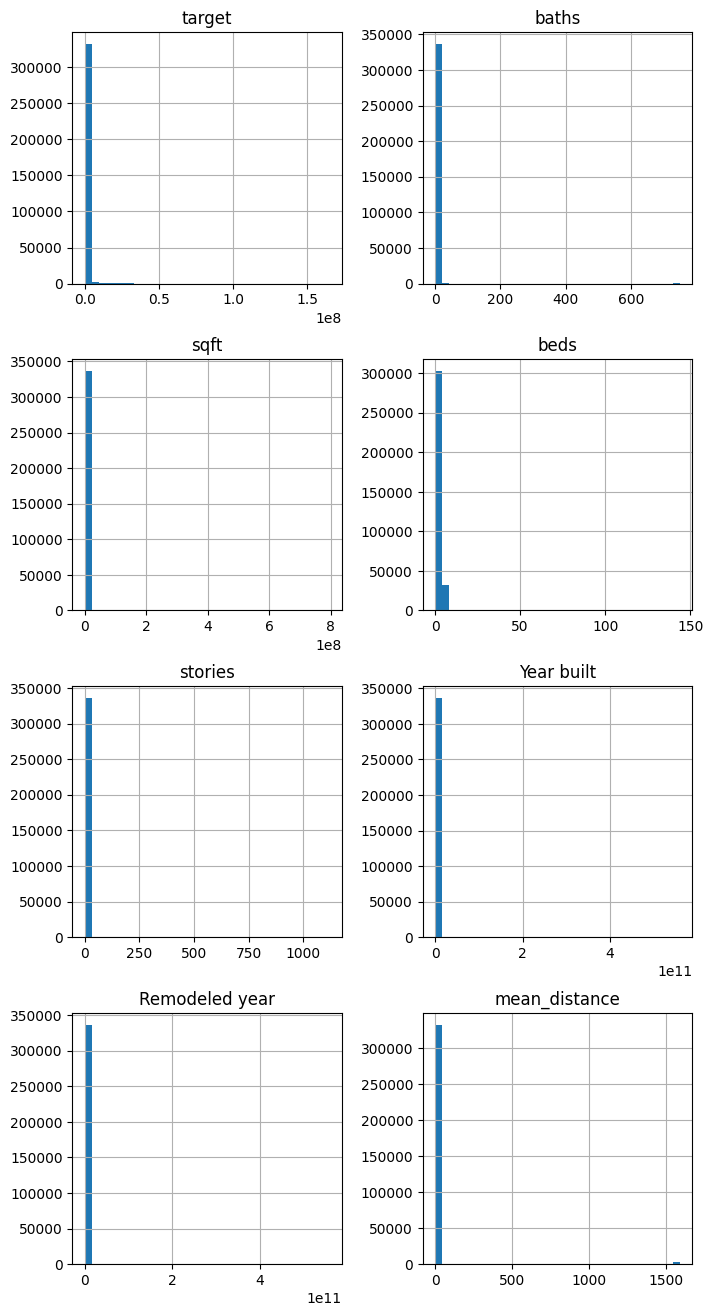

In [37]:
# Посмотрим на гистограммы не бинарных признаков, в которых могут быть выбросы
temp_df = clean_data[['target', 'baths', 'sqft', 'beds', 'stories', 'Year built', 'Remodeled year', 'mean_distance']]
ax_list = temp_df.hist(bins=35, layout=(4,2), figsize=(8,16))

*В каждом из 8 признаков явно видны выбросы. Избавимся от них*

### target

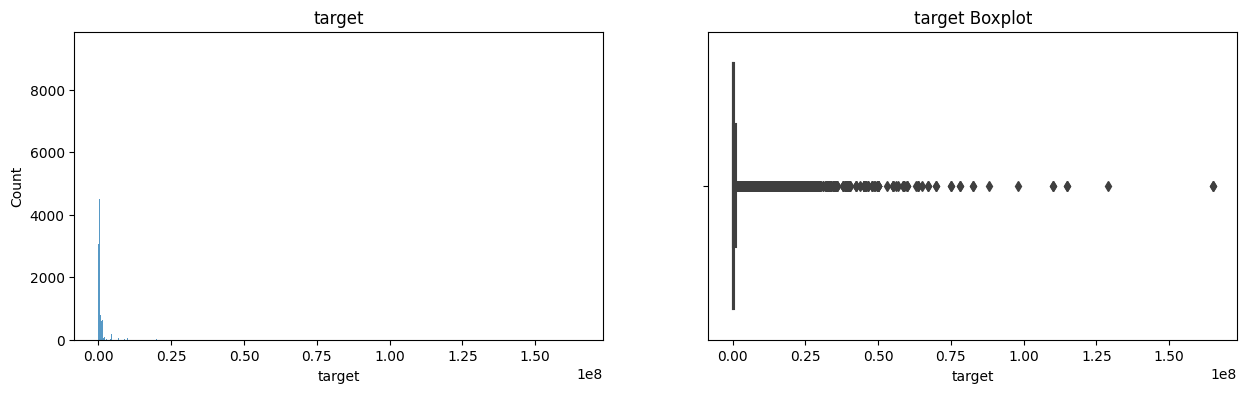

In [38]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(15, 4))
histplot = sns.histplot(data=clean_data, x='target', ax=axes[0]);
histplot.set_title('target');
boxplot = sns.boxplot(data=clean_data, x='target', ax=axes[1]);
boxplot.set_title('target Boxplot');

*удалим все строки с ценой меньше 1000*

In [39]:
clean_data = clean_data[clean_data.target>1000].reset_index(drop=True)

*Избавимся от выбросов методом межквартильного размаха, ослабив правую гравницу*

In [40]:
outliers, clean_data = outliers_iqr_mod(clean_data, 'target', left=1.5, right=6)
print(f'Число выбросов по методу Тьюки: {outliers.shape[0]}')
print(f'Результирующее число записей: {clean_data.shape[0]}')

Число выбросов по методу Тьюки: 8773
Результирующее число записей: 326798


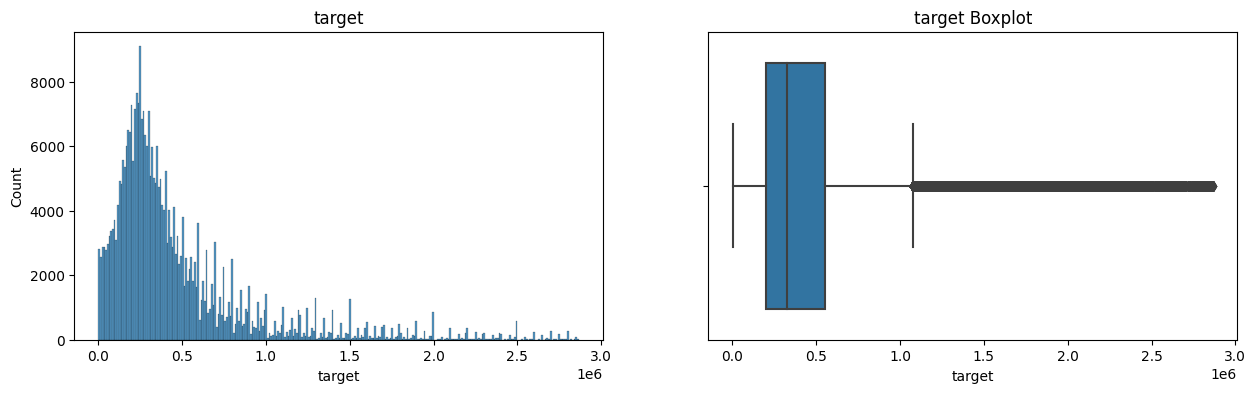

In [41]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(15, 4))
histplot = sns.histplot(data=clean_data, x='target', ax=axes[0]);
histplot.set_title('target');
boxplot = sns.boxplot(data=clean_data, x='target', ax=axes[1]);
boxplot.set_title('target Boxplot');

### baths

In [42]:
#Удалим строки где ванн > 20
clean_data = clean_data[clean_data.baths<=20].reset_index(drop=True)

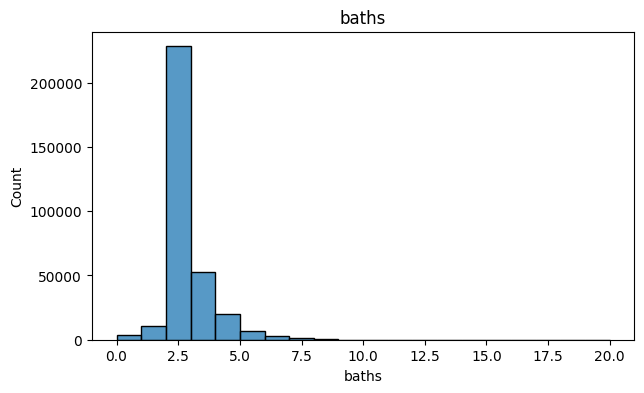

In [43]:
fig, axes = plt.subplots(figsize=(7, 4))
histplot = sns.histplot(bins=20, data=clean_data, x='baths');
histplot.set_title('baths');


### sqft

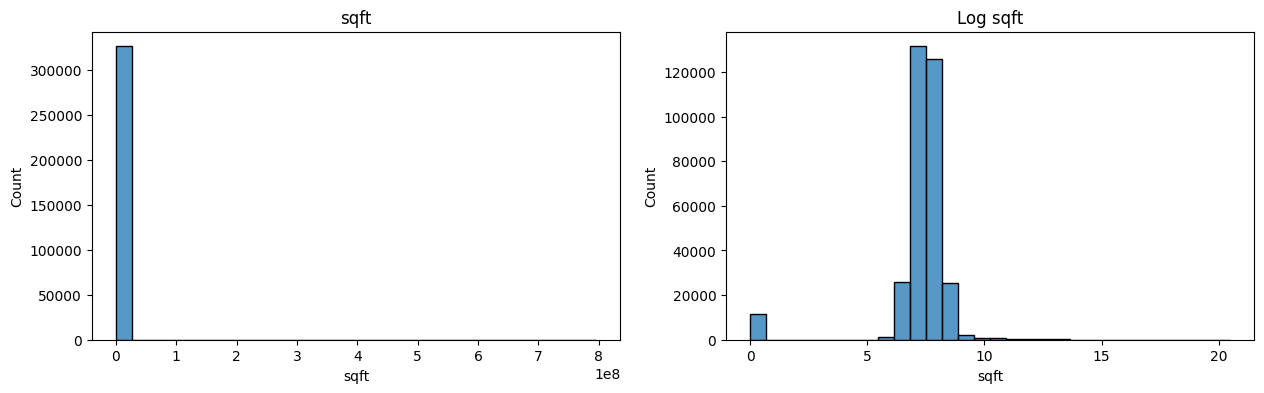

In [44]:
fig, axes = plt.subplots(1, 2, figsize=(15, 4))

#гистограмма исходного признака
histplot = sns.histplot(clean_data['sqft'], bins=30, ax=axes[0])
histplot.set_title('sqft');

#гистограмма в логарифмическом масштабе
log_sqft= np.log(clean_data['sqft'] + 1)
histplot = sns.histplot(log_sqft , bins=30, ax=axes[1])
histplot.set_title('Log sqft');


*Видно анамально маленькие площади, начнем с удаления всех площадей меньше 50 sqft*

Число выбросов по методу Тьюки: 3419
Результирующее число записей: 311336


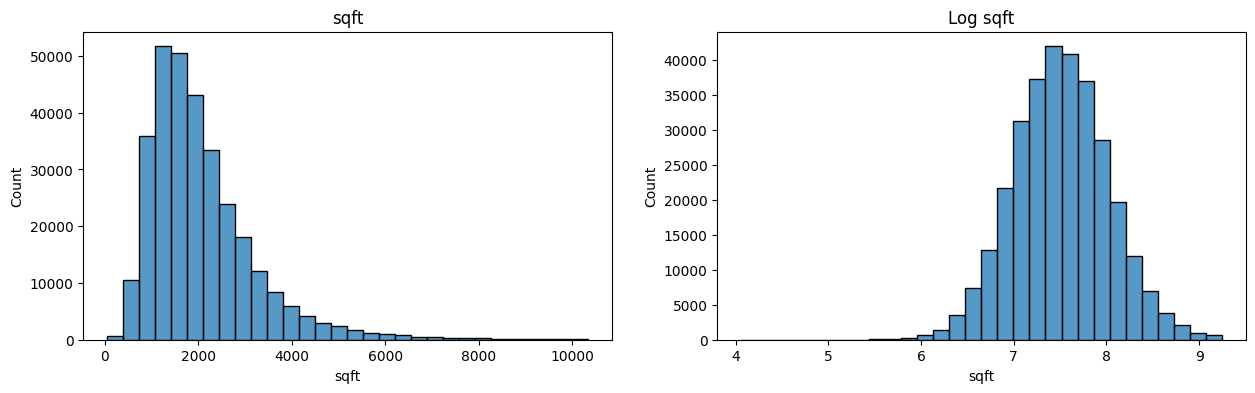

In [45]:
clean_data = clean_data[clean_data.sqft>50]

outliers, clean_data = outliers_iqr_mod(clean_data, 'sqft', left=1, right=6)
print(f'Число выбросов по методу Тьюки: {outliers.shape[0]}')
print(f'Результирующее число записей: {clean_data.shape[0]}')

fig, axes = plt.subplots(1, 2, figsize=(15, 4))

#гистограмма исходного признака
histplot = sns.histplot(clean_data['sqft'], bins=30, ax=axes[0])
histplot.set_title('sqft');

#гистограмма в логарифмическом масштабе
log_sqft= np.log(clean_data['sqft'] + 1)
histplot = sns.histplot(log_sqft , bins=30, ax=axes[1])
histplot.set_title('Log sqft');



### beds

Text(0.5, 1.0, 'beds')

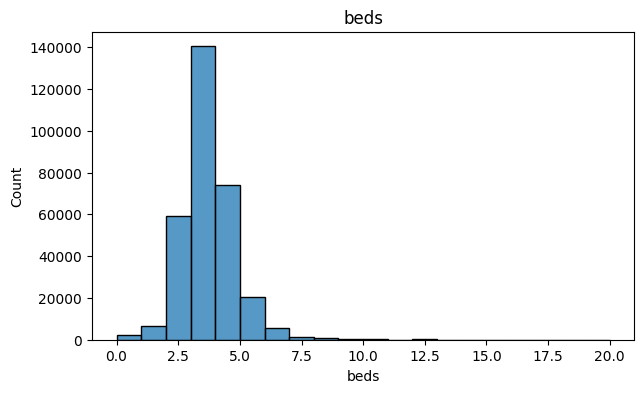

In [46]:
# Удалим строки где beds > 20
clean_data = clean_data[clean_data.beds<=20].reset_index(drop=True)

fig, axes = plt.subplots(figsize=(7, 4))
histplot = sns.histplot(bins=20, data=clean_data, x='beds')
histplot.set_title('beds')

### stories

Text(0.5, 1.0, 'stories')

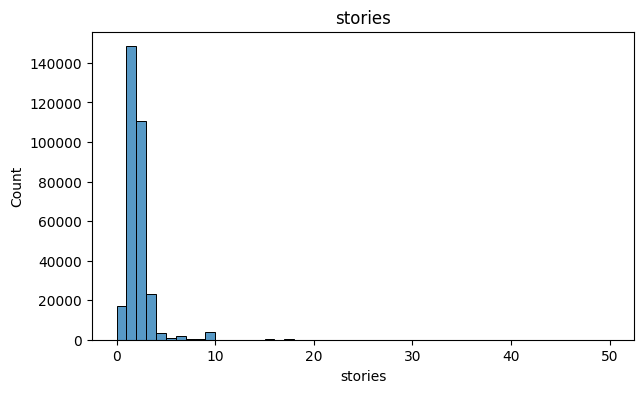

In [47]:
# Удалим строки где stories > 50
clean_data = clean_data[clean_data.stories<=50].reset_index(drop=True)

fig, axes = plt.subplots(figsize=(7, 4))
histplot = sns.histplot(bins=50, data=clean_data, x='stories')
histplot.set_title('stories')

### Year built,	Remodeled year

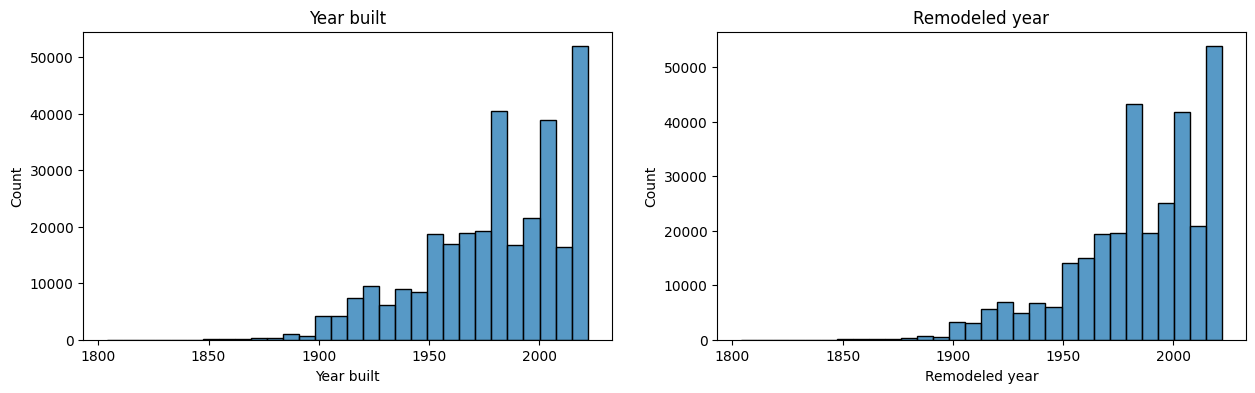

In [48]:
# Удалим строки где год постройки < 1800 и >2023
clean_data = clean_data[(clean_data['Year built'] > 1800) & (clean_data['Year built'] < 2024)].reset_index(drop=True)

fig, axes = plt.subplots(1, 2, figsize=(15, 4))
histplot = sns.histplot(data=clean_data, x='Year built', bins=30, ax=axes[0])
histplot.set_title('Year built')

histplot = sns.histplot(data=clean_data, x='Remodeled year', bins=30, ax=axes[1])
histplot.set_title('Remodeled year');

### mean_distance

Text(0.5, 1.0, 'mean_distance')

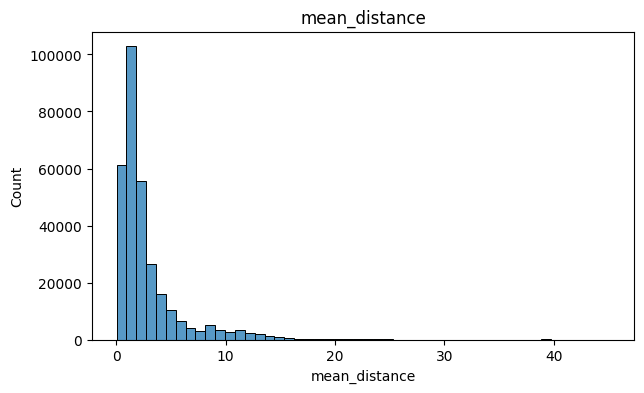

In [49]:
clean_data[clean_data.mean_distance > 100]

# Удалим строки где mean_distance > 100
clean_data = clean_data[clean_data.mean_distance<=100].reset_index(drop=True)

fig, axes = plt.subplots(figsize=(7, 4))
histplot = sns.histplot(bins=50, data=clean_data, x='mean_distance')
histplot.set_title('mean_distance')

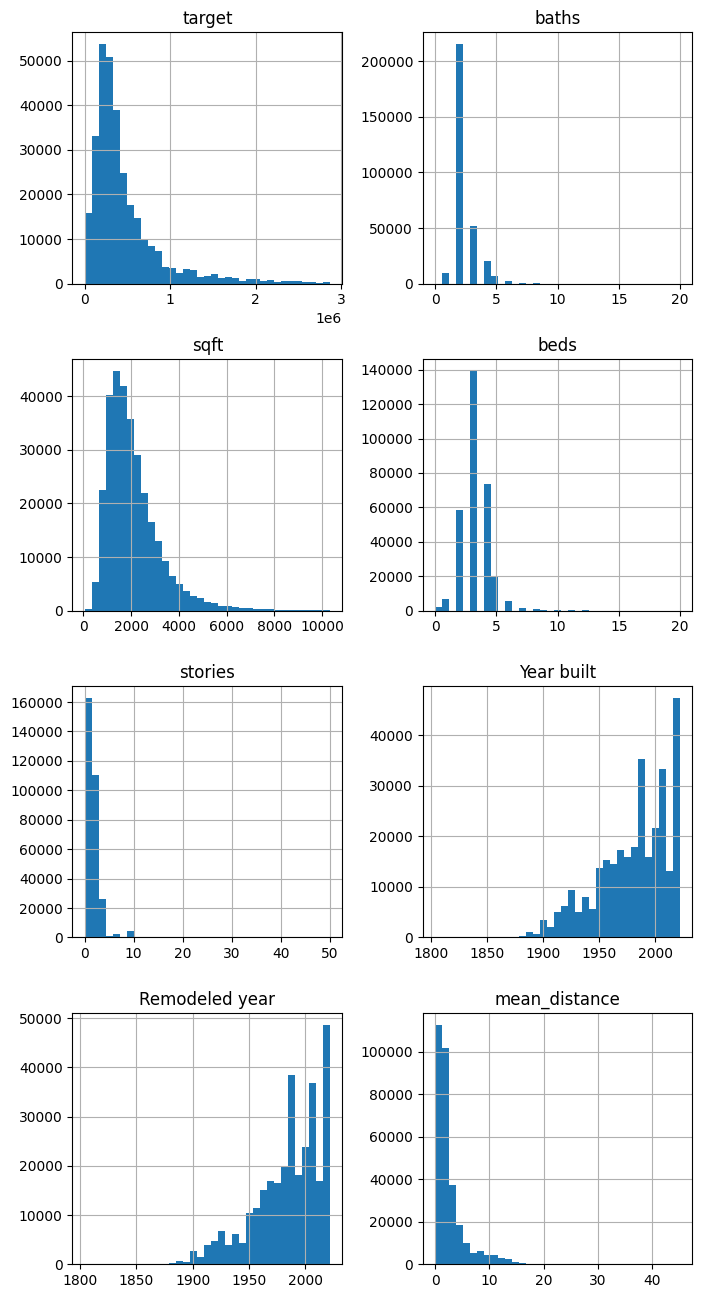

In [50]:
# Посмотрим на гистограммы еще раз
temp_df = clean_data[['target', 'baths', 'sqft', 'beds', 'stories', 'Year built', 'Remodeled year', 'mean_distance']]
ax_list = temp_df.hist(bins=35, layout=(4,2), figsize=(8,16))

<AxesSubplot: >

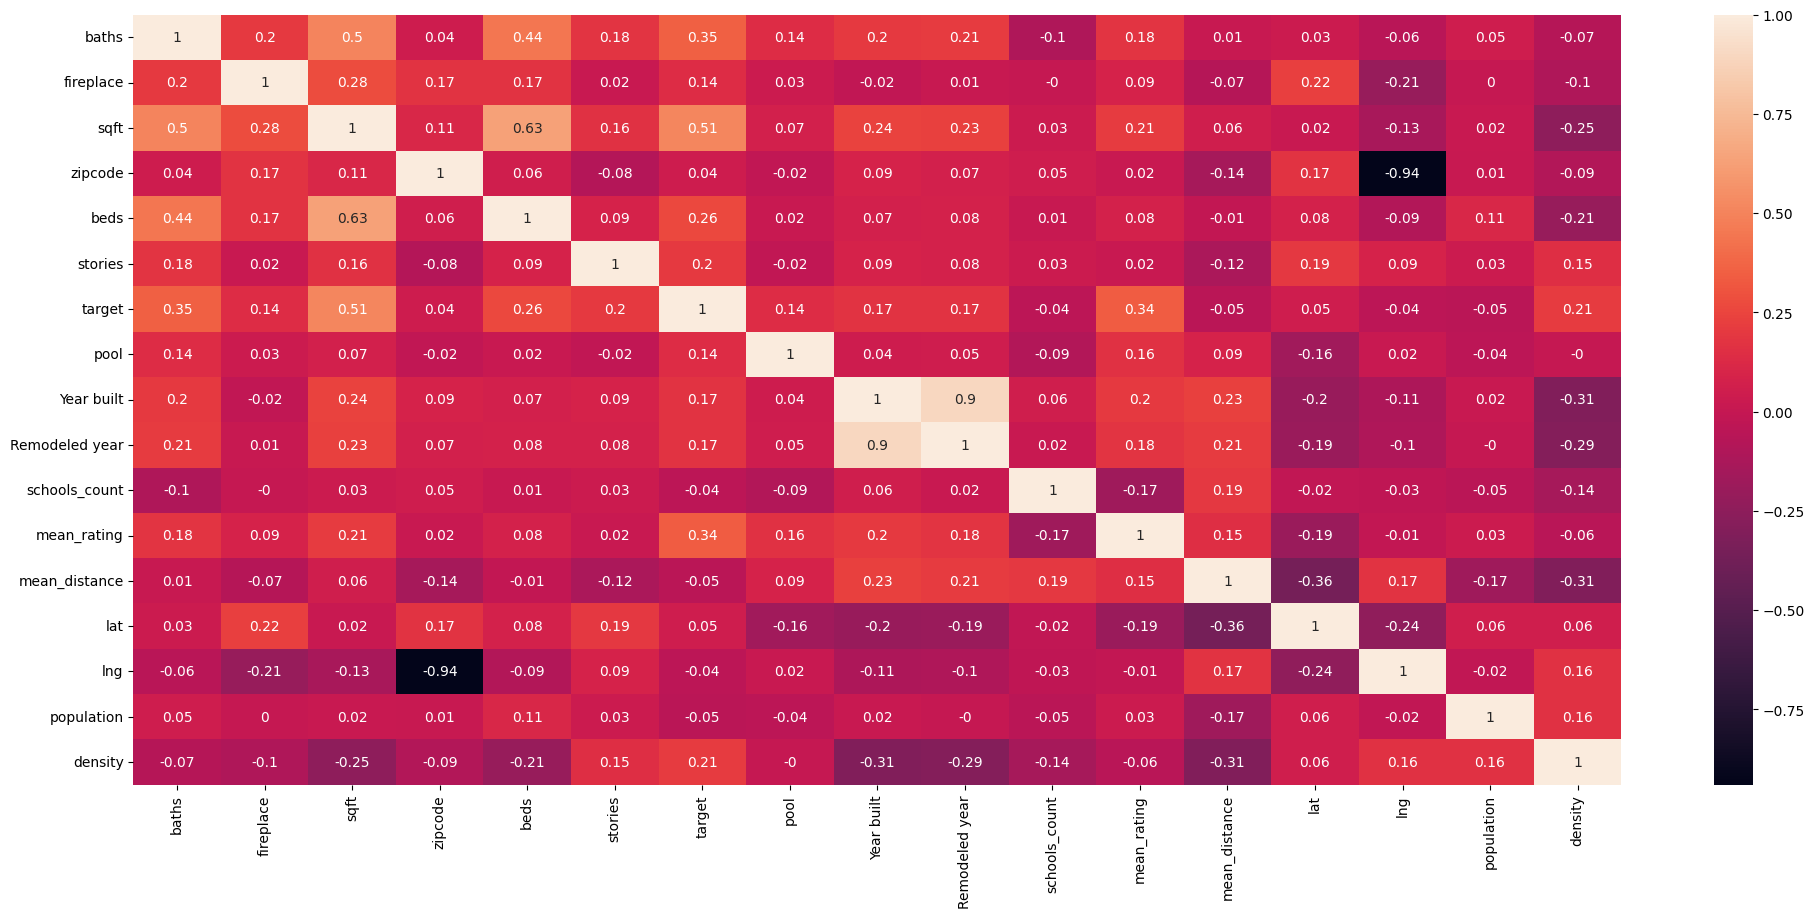

In [51]:
# Посмотрим на матрицу корреляций
fig, axes = plt.subplots(figsize=(24, 10))
sns.heatmap(round(clean_data.corr(method='spearman'), 2), annot=True)

*Сразу видно сильную корреляцию zipcode-lng(-0.94) и Year build-Remodeled Year(0.9).*

*По сути street, city, state, zipcode повторяют координаты и проще их удалить. Плюс на этапе предсказания и получения данных от пользователя можно запрашивать координаты, которые быстро обработаются, вместо текстовых полей с адресом объекта*

In [52]:
# Удалим коррелирующие признаки
clean_data = clean_data.drop(['street', 'city', 'state', 'zipcode', 'Remodeled year'], axis=1)
clean_data.shape

(308732, 17)

In [53]:
clean_data

,status,propertyType,baths,fireplace,sqft,beds,stories,target,pool,Year built,schools_count,mean_rating,mean_distance,lat,lng,population,density
0,active,single-family home,2.0,1,2900.0,4.0,1.0,418000.0,0,2019.0,8,3.25,5.54,35.18059,-79.37566,15158.0,198.2
1,for sale,single-family home,3.0,0,1947.0,3.0,2.0,310000.0,0,2019.0,3,2.67,1.33,47.68142,-117.20826,27597.0,748.6
2,for sale,single-family home,8.0,1,6457.0,5.0,3.0,2395000.0,0,2006.0,4,9.25,0.75,32.83657,-96.79617,24804.0,2191.5
3,active,other,2.0,0,1507.0,3.0,1.0,181500.0,0,2006.0,4,1.75,3.83,28.09113,-81.43774,39453.0,202.0
4,active,single-family home,2.0,0,3588.0,3.0,1.0,244900.0,0,1970.0,6,3.17,6.35,43.15389,-93.20006,29024.0,75.6
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
308727,no status,single-family home,2.0,0,4017.0,5.0,0.0,1249000.0,1,1990.0,2,7.50,16.60,25.96145,-80.14150,32925.0,3897.4
308728,for sale,condo,3.0,0,2000.0,3.0,9.0,674999.0,0,1924.0,3,4.33,4.14,41.93965,-87.65495,72113.0,12804.2
308729,for sale,single-family home,3.0,0,1152.0,3.0,2.0,528000.0,0,1950.0,2,4.50,0.60,40.67683,-73.77623,66424.0,7902.5
308730,no status,other,2.0,0,8479.0,3.0,2.0,34500.0,0,1985.0,3,0.00,1.23,29.82471,-95.28668,19506.0,826.7


*У нас осталось 380732 строки и 17 признаков, по которым можно строить модель. Посмотрим на данные еще и перейдём к построению моделей.*

In [54]:
# И сохраним получившийся датафрейм в файл
clean_data.to_csv('data/data_cleaned2.csv', index=False)

-----
## Визуализация данных

In [55]:
clean_data = pd.read_csv('data/data_cleaned2.csv')
clean_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 308732 entries, 0 to 308731
Data columns (total 17 columns):
 #   Column         Non-Null Count   Dtype  
---  ------         --------------   -----  
 0   status         308732 non-null  object 
 1   propertyType   308732 non-null  object 
 2   baths          308732 non-null  float64
 3   fireplace      308732 non-null  int64  
 4   sqft           308732 non-null  float64
 5   beds           308732 non-null  float64
 6   stories        308732 non-null  float64
 7   target         308732 non-null  float64
 8   pool           308732 non-null  int64  
 9   Year built     308732 non-null  float64
 10  schools_count  308732 non-null  int64  
 11  mean_rating    308732 non-null  float64
 12  mean_distance  308732 non-null  float64
 13  lat            308732 non-null  float64
 14  lng            308732 non-null  float64
 15  population     308732 non-null  float64
 16  density        308732 non-null  float64
dtypes: float64(12), int64(3), obj

In [56]:
#считаем медианную стоимость для каждого статуса
bar_data = clean_data.groupby(
    by='status',
    as_index=False
)[['target']].median()

#строим график
fig = px.bar(
    data_frame=bar_data, #датафрейм
    x='status', #ось x
    y='target', #ось y
    color='status', #расцветка в зависимости от страны
    text = 'target', #текст на столбцах
    orientation='v', #ориентация графика
    height=500, #высота
    width=1000, #ширина
    title='status for target' #заголовок
)

#отображаем его
fig.show()

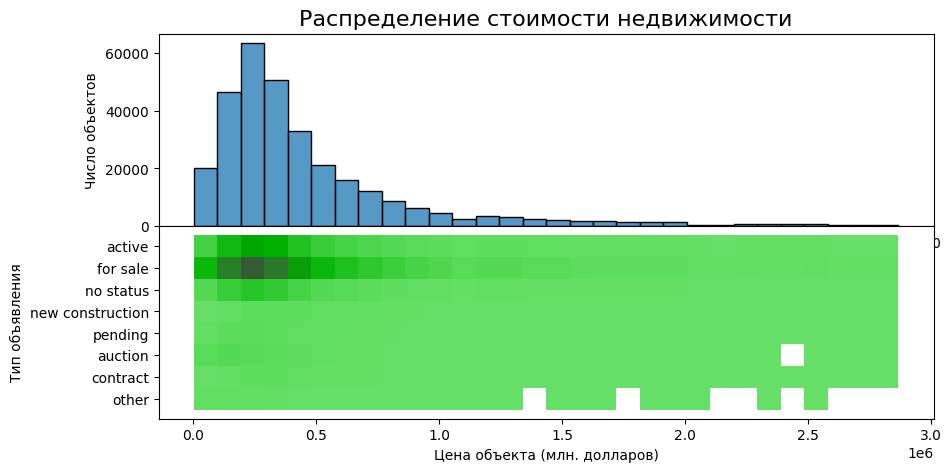

In [57]:
fig, axes = plt.subplots(nrows=2, ncols=1, figsize=(10, 5))
plt.subplots_adjust(hspace=.0)

histplot1 = sns.histplot(
    data=clean_data, 
    x='target', 
    bins=30,
    ax=axes[0],
)
histplot1.set_title('Распределение стоимости недвижимости', fontsize=16)
histplot1.set_xlabel('Цена объекта (млн. долларов)')
histplot1.set_ylabel('Число объектов')

histplot2 = sns.histplot(
    data=clean_data,
    x='target',
    y='status',
    bins=30,
    color='green',
    ax=axes[1]
)
histplot2.set_xlabel('Цена объекта (млн. долларов)')
histplot2.set_ylabel('Тип объявления');

*Самая высокая медианная цена у новостроек, самые низкие на аукционах и в разделе other*

*Самые частые объявления встречаются со статусами active, for sale и no status по цене около 200000-400000*

In [58]:
#считаем медианную стоимость для каждого propertyType
bar_data = clean_data.groupby(
    by='propertyType',
    as_index=False
)[['target']].median()

#строим график
fig = px.bar(
    data_frame=bar_data, #датафрейм
    x='propertyType', #ось x
    y='target', #ось y
    color='propertyType', #расцветка в зависимости от страны
    text = 'target', #текст на столбцах
    orientation='v', #ориентация графика
    height=500, #высота
    width=1000, #ширина
    title='propertyType for target' #заголовок
)

#отображаем его
fig.show()

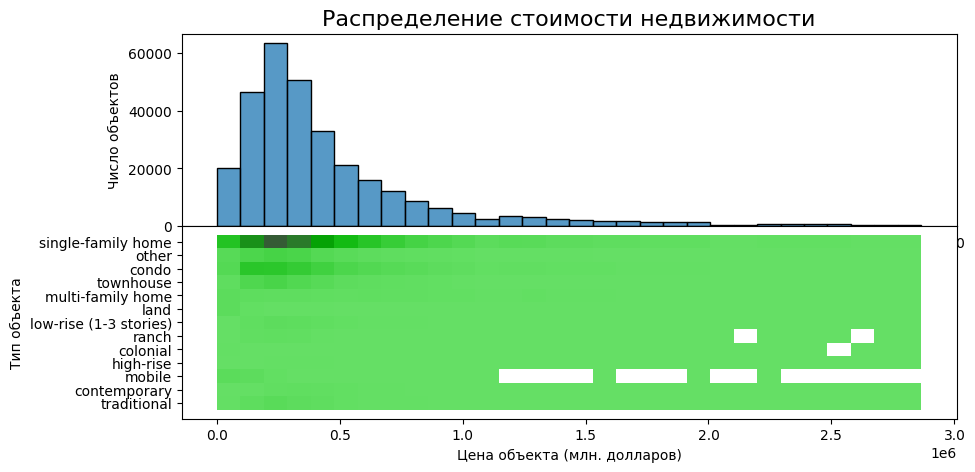

In [59]:
fig, axes = plt.subplots(nrows=2, ncols=1, figsize=(10, 5))
plt.subplots_adjust(hspace=.0)

histplot1 = sns.histplot(
    data=clean_data, 
    x='target', 
    bins=30,
    ax=axes[0],
)
histplot1.set_title('Распределение стоимости недвижимости', fontsize=16)
histplot1.set_xlabel('Цена объекта (млн. долларов)')
histplot1.set_ylabel('Число объектов')

histplot2 = sns.histplot(
    data=clean_data,
    x='target',
    y='propertyType',
    bins=30,
    color='green',
    ax=axes[1]
)
histplot2.set_xlabel('Цена объекта (млн. долларов)')
histplot2.set_ylabel('Тип объекта');

*Самая высокая медианная цена у multi-family (видимо для нескольких семей чаще всего дома большие), самые низкие у mobile и в land*

*Самые частые объявления встречаются со статусами single-family по цене около 200000-500000*

In [60]:
#считаем медианную стоимость для каждого статуса
bar_data = clean_data.groupby(
    by='baths',
    as_index=False
)[['target']].median()

#строим график
fig = px.bar(
    data_frame=bar_data, #датафрейм
    x='baths', #ось x
    y='target', #ось y
    text = 'target', #текст на столбцах
    orientation='v', #ориентация графика
    height=500, #высота
    width=1000, #ширина
    title='baths for target' #заголовок
)

#отображаем его
fig.show()

In [61]:
#считаем медианную стоимость для каждого статуса
bar_data = clean_data.groupby(
    by='beds',
    as_index=False
)[['target']].median()

#строим график
fig = px.bar(
    data_frame=bar_data, #датафрейм
    x='beds', #ось x
    y='target', #ось y
    text = 'target', #текст на столбцах
    orientation='v', #ориентация графика
    height=500, #высота
    width=1000, #ширина
    title='beds for target' #заголовок
)

#отображаем его
fig.show()

In [62]:
line_data = clean_data.groupby('Year built', as_index=False)['target'].median()
fig = px.line(
    data_frame=line_data, #датафрейм
    x='Year built', #ось абсцисс
    y='target', #ось ординат
    height=500, #высота
    width=1000, #ширина
    title='Распределение стоимости в зависимости от года строения' #заголовок
)
fig.show()

*Все объявления с годом ниже 1900 очень разнообразны в цене, от стандартной медианной цены до приближающейся к 3 миллионам*

*И новостройки дороги в цене*

---
### Построение модели

### Линейная регрессия

*Начнем с деления данных на тренировочную и тестовую выборки и построения базовой модели линейной регрессии*

In [63]:
clean_data = pd.read_csv('data/data_cleaned2.csv')
clean_data.info()
model_df = pd.DataFrame()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 308732 entries, 0 to 308731
Data columns (total 17 columns):
 #   Column         Non-Null Count   Dtype  
---  ------         --------------   -----  
 0   status         308732 non-null  object 
 1   propertyType   308732 non-null  object 
 2   baths          308732 non-null  float64
 3   fireplace      308732 non-null  int64  
 4   sqft           308732 non-null  float64
 5   beds           308732 non-null  float64
 6   stories        308732 non-null  float64
 7   target         308732 non-null  float64
 8   pool           308732 non-null  int64  
 9   Year built     308732 non-null  float64
 10  schools_count  308732 non-null  int64  
 11  mean_rating    308732 non-null  float64
 12  mean_distance  308732 non-null  float64
 13  lat            308732 non-null  float64
 14  lng            308732 non-null  float64
 15  population     308732 non-null  float64
 16  density        308732 non-null  float64
dtypes: float64(12), int64(3), obj

*У нас 2 параметра типа object остальные числовые. Нужно закодировать object и номализовать данные для обучения базовой линейной регрессии*

In [64]:
# Разделим выборку 
X = clean_data.drop(['target'], axis=1)
y = clean_data['target']

# Закодируем категориальные столбцы
X = pd.get_dummies(X, columns=['status'], drop_first=True)
X = pd.get_dummies(X, columns=['propertyType'], drop_first=True)

# Делим на тренировочную и тестовую
X_train, X_test, y_train, y_test = model_selection.train_test_split(X, y, 
                                                                    test_size=0.20, 
                                                                    random_state=42,
                                                                    shuffle=True)

# нормализуем данные
scaler = preprocessing.StandardScaler()
scaler.fit(X_train)
X_train_scal = pd.DataFrame(scaler.transform(X_train), columns=X_train.columns)
X_test_scal = pd.DataFrame(scaler.transform(X_test), columns=X_test.columns)

In [65]:
# Линейная регрессия
lin_reg = LinearRegression()
# Обучаем модель
lin_reg.fit(X_train_scal, y_train)

y_train_pred = lin_reg.predict(X_train_scal)
y_test_pred = lin_reg.predict(X_test_scal)

model_df = metrics_fun(y_train, 
                       y_train_pred, 
                       y_test,
                       y_test_pred, 
                       model_df, 
                       'без указания параметров', 
                       'Линейная регрессия')

	 Train 		 Test
MAE: 	 202216.67 	 202207.98
MSE: 	 102307068774 	 102421929790
R2: 	 0.46 		 0.46
MAPE: 	 93.398 % 	 93.407 %


*Базовая модель показала плохой результат. Отберем лучшие признаки и попробуем полиноминальную регрессию*

In [66]:
# отберем 15 лучших для предсказания признаков
estimator = LinearRegression()
selector = RFE(estimator, n_features_to_select=15, step=1)
selector.fit(X_train_scal, y_train)

cols = selector.get_feature_names_out()
cols

array(['baths', 'sqft', 'pool', 'Year built', 'mean_rating', 'lng',
       'population', 'density', 'status_auction', 'status_for sale',
       'status_no status', 'status_other', 'propertyType_condo',
       'propertyType_mobile', 'propertyType_multi-family home'],
      dtype=object)

In [67]:
# Полиноминальная решрессия на лучших признаках
poly = preprocessing.PolynomialFeatures(degree=2, include_bias=True)

poly.fit(X_train[cols])
X_train_poly = poly.transform(X_train[cols])
X_test_poly = poly.transform(X_test[cols])

model_lin_poly = LinearRegression()
model_lin_poly.fit(X_train_poly, y_train)
y_train_pred = model_lin_poly.predict(X_train_poly)
y_test_pred = model_lin_poly.predict(X_test_poly)

model_df = metrics_fun(y_train, 
                       y_train_pred, 
                       y_test, 
                       y_test_pred, 
                       model_df, 
                       '{degree=2, include_bias=True}', 
                       'Полиноминальная регрессия')

	 Train 		 Test
MAE: 	 175317.51 	 174649.04
MSE: 	 79299636910 	 79128376506
R2: 	 0.58 		 0.58
MAPE: 	 74.177 % 	 72.501 %


*Результат получше, но попробуем другие модели*

In [68]:
# Деревья решений
dt_reg = tree.DecisionTreeRegressor(random_state=42)
# Обучаем модель
dt_reg.fit(X_train, y_train)

y_train_pred = dt_reg.predict(X_train)
y_test_pred = dt_reg.predict(X_test)

model_df = metrics_fun(y_train, y_train_pred, y_test, y_test_pred, model_df, dt_reg, 'Деревья решений')

	 Train 		 Test
MAE: 	 869.92 	 108484.64
MSE: 	 108170574 	 56872878967
R2: 	 1.00 		 0.70
MAPE: 	 0.181 % 	 51.210 %


*Как и ожидалось без указания глубины видим переобучение. Модель выучила тренировочные данные и показала результат хуже на тестовых (хоть этот результат и лучше полиноминальной регрессии)*

*Попробуем подобрать параметры*

In [69]:
def optuna_rf(trial):
  """
  Функция для подбора гиперпараметров
  """
  
  # задаем пространства поиска гиперпараметров
  max_depth = trial.suggest_int('max_depth', 10, 30, 1)
  min_samples_leaf = trial.suggest_int('min_samples_leaf', 2, 15, 1)

  # создаем модель
  model = tree.DecisionTreeRegressor(max_depth=max_depth,
                                      min_samples_leaf=min_samples_leaf,
                                      random_state=42)
  # обучаем модель
  model.fit(X_train, y_train)
  score = metrics.r2_score(y_test, model.predict(X_test))

  return score

# cоздаем объект исследования
# можем напрямую указать, что нам необходимо максимизировать метрику direction="maximize"
study = optuna.create_study(study_name="DecisionTreeRegressor", direction="maximize")
# ищем лучшую комбинацию гиперпараметров n_trials раз
study.optimize(optuna_rf, n_trials=30)
# выводим результаты на обучающей выборке
print("Наилучшие значения гиперпараметров {}".format(study.best_params))
print("R2 на тестовом наборе: {:.2f}".format(study.best_value))

[I 2023-11-05 12:23:10,503] A new study created in memory with name: DecisionTreeRegressor


[I 2023-11-05 12:23:17,520] Trial 0 finished with value: 0.7509082138222172 and parameters: {'max_depth': 28, 'min_samples_leaf': 9}. Best is trial 0 with value: 0.7509082138222172.
[I 2023-11-05 12:23:22,927] Trial 1 finished with value: 0.7115534151850332 and parameters: {'max_depth': 12, 'min_samples_leaf': 4}. Best is trial 0 with value: 0.7509082138222172.
[I 2023-11-05 12:23:28,536] Trial 2 finished with value: 0.7271027151492986 and parameters: {'max_depth': 14, 'min_samples_leaf': 3}. Best is trial 0 with value: 0.7509082138222172.
[I 2023-11-05 12:23:34,802] Trial 3 finished with value: 0.7492566619484491 and parameters: {'max_depth': 23, 'min_samples_leaf': 12}. Best is trial 0 with value: 0.7509082138222172.
[I 2023-11-05 12:23:38,880] Trial 4 finished with value: 0.6965110592867176 and parameters: {'max_depth': 11, 'min_samples_leaf': 10}. Best is trial 0 with value: 0.7509082138222172.
[I 2023-11-05 12:23:44,895] Trial 5 finished with value: 0.7403736927937286 and paramete

Наилучшие значения гиперпараметров {'max_depth': 30, 'min_samples_leaf': 10}
R2 на тестовом наборе: 0.75


In [70]:
# Деревья решений на лучших значениях
dt_reg = tree.DecisionTreeRegressor(random_state=42, 
                                    max_depth=30, 
                                    min_samples_leaf=10)
# Обучаем модель
dt_reg.fit(X_train, y_train)

y_train_pred = dt_reg.predict(X_train)
y_test_pred = dt_reg.predict(X_test)

model_df = metrics_fun(y_train, 
                       y_train_pred, 
                       y_test, 
                       y_test_pred, 
                       model_df, 
                       '{random_state=42, max_depth=30, min_samples_leaf=10}', 
                       'Деревья решений (с параметрами optuna)')

	 Train 		 Test
MAE: 	 86225.05 	 113752.58
MSE: 	 27160156014 	 46804469367
R2: 	 0.86 		 0.75
MAPE: 	 40.646 % 	 53.269 %


*Несмотря на большую глубину и намеки на переобучение это пока лучший результат*

In [71]:
# градиентный бустинг
gb_reg = GradientBoostingRegressor(max_depth=10,
                                    n_estimators=500,
                                    random_state=42,
                                    learning_rate=0.01)
# Обучаем модель
gb_reg.fit(X_train, y_train)

y_train_pred  = gb_reg.predict(X_train)
y_test_pred = gb_reg.predict(X_test)

model_df = metrics_fun(y_train, 
                       y_train_pred, 
                       y_test, 
                       y_test_pred, 
                       model_df, 
                       '{max_depth=10, n_estimators=500, random_state=42, learning_rate=0.01}', 
                       'Градиентный бустинг')

	 Train 		 Test
MAE: 	 90943.44 	 103432.66
MSE: 	 22783056874 	 33585385528
R2: 	 0.88 		 0.82
MAPE: 	 41.256 % 	 45.394 %


*Теперь градиентный бустинг перехватывает лучший результат*

In [72]:
# Случайный лес
rf_reg = ensemble.RandomForestRegressor(n_estimators=200, 
                                        criterion='squared_error', 
                                        max_depth=10, 
                                        random_state=42)

# Обучаем модель
rf_reg.fit(X_train, y_train)

y_train_pred = rf_reg.predict(X_train)
y_test_pred = rf_reg.predict(X_test)

model_df = metrics_fun(y_train, 
                       y_train_pred, 
                       y_test, 
                       y_test_pred, 
                       model_df, 
                       "{n_estimators=200, criterion='squared_error', max_depth=10, random_state=42}", 
                       "Случайный лес")

	 Train 		 Test
MAE: 	 131577.59 	 136871.57
MSE: 	 46158779843 	 51660217180
R2: 	 0.76 		 0.73
MAPE: 	 71.271 % 	 70.343 %


*Высокие показатели, но слабее градиентного бустинга*

In [73]:
# catboost
cb = CatBoostRegressor(random_state=42, verbose=False)
# Обучаем модель
cb.fit(X_train, y_train)

y_train_pred  = cb.predict(X_train)
y_test_pred = cb.predict(X_test)

model_df = metrics_fun(y_train, 
                       y_train_pred, 
                       y_test, 
                       y_test_pred, 
                       model_df, 
                       '{random_state=42, verbose=False}', 
                       'catboost')

	 Train 		 Test
MAE: 	 101616.18 	 105319.90
MSE: 	 31293087931 	 34432048185
R2: 	 0.83 		 0.82
MAPE: 	 42.026 % 	 40.320 %


*Быстрое обучение с минимальными параметрами и высоким результатом*

*Посмотрим на итоговую таблицу моделей*

In [74]:
model_df

,model_name,model_params,R2_train,R2_test
4,Градиентный бустинг,"{max_depth=10, n_estimators=500, random_state=...",0.88,0.82
6,catboost,"{random_state=42, verbose=False}",0.83,0.82
3,Деревья решений (с параметрами optuna),"{random_state=42, max_depth=30, min_samples_le...",0.86,0.75
5,Случайный лес,"{n_estimators=200, criterion='squared_error', ...",0.76,0.73
2,Деревья решений,DecisionTreeRegressor(random_state=42),1.00,0.70
1,Полиноминальная регрессия,"{degree=2, include_bias=True}",0.58,0.58
0,Линейная регрессия,без указания параметров,0.46,0.46


*По R2 метрике градиентный бустинг победил, да и то засчёт тренировочных данных. Но по MAPE catboost впереди. Остановимся на catboost. Учитывая внедрение на страницу сайта и некоторый опросник для прогноза, подберем самые важные признаки*

<AxesSubplot: ylabel='feature_names'>

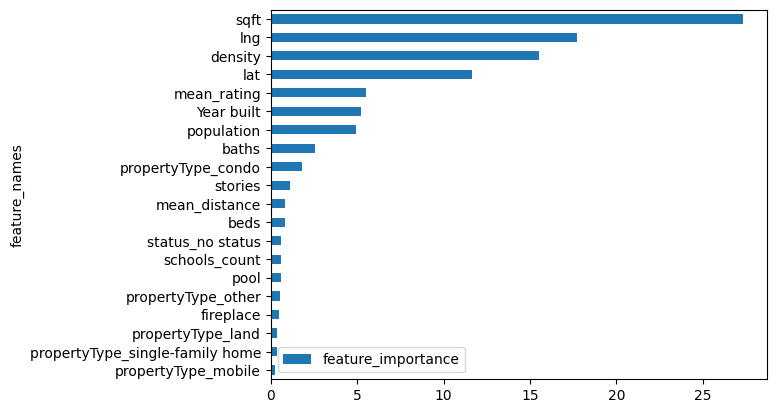

In [75]:
# Соберем в датафрейм важные признаки
best_feature = pd.DataFrame({'feature_importance': cb.get_feature_importance(), 
              'feature_names': X_train.columns}).sort_values(by=['feature_importance'], 
                                                       ascending=False)

#Построим гистограмму
best_feature[:20].sort_values(by=['feature_importance'], ascending=True).plot.barh(x='feature_names', y='feature_importance')

*В первые ряды ожидаемо попала площадь и координаты. Возьмем самые значимые признаки*

*В опроснике будут первые 12 признаков. Проверим модель на них*

In [76]:
best = best_feature['feature_names'][:12]

cb_best = CatBoostRegressor(random_state=42, verbose=False)
cb_best.fit(X_train[best], y_train)

y_train_pred  = cb_best.predict(X_train[best])
y_test_pred = cb_best.predict(X_test[best])

model_df = metrics_fun(y_train, 
                       y_train_pred, 
                       y_test, 
                       y_test_pred, 
                       model_df, 
                       '{random_state=42, verbose=False}', 
                       'catboost на лучших признаках')

	 Train 		 Test
MAE: 	 104714.96 	 108438.17
MSE: 	 33350351804 	 36433878162
R2: 	 0.82 		 0.81
MAPE: 	 56.746 % 	 55.045 %


*Показатели модели почти не изменились. Сохраним модель*

In [77]:
with open('models/model.pkl', 'wb') as output:
    pickle.dump(cb_best, output)

*Модель готова. В файлах server.py и client.py доступно тестирование работоспособности модели. Можно единичным запросом (закомментировано), либо автоматические рандомные запросы, сервер будет на них отвечать предсказанием цены*